# Maximizing Profits with a Simple Integer Linear Program in Python

Below is an end-to-end example (in Python) of how you can:

1. **Formulate** the problem as an Integer Linear Program (ILP).
2. **Generate** some *simulated data* for banks, products, revenues, and costs.
3. **Implement** the model using [PuLP](https://coin-or.github.io/pulp/).
4. **Solve** the model to maximize profits.
5. **Visualize** the resulting assignment (how many leads go to each bank-product combination).

> **Note**: We are not using sub-products or hierarchical product constraints here, as per your request.
> We keep the model straightforward, but the same structure can be extended or adjusted to fit additional real-world constraints.

---

## 1. Key Model Overview

We have a set of banks $ i \in \{1, \ldots, I\} $ and a set of products $ j \in \{1, \ldots, J\} $.

- Decision variable:
  $$
  x_{i,j} = \text{(integer) number of leads allocated to bank } i \text{ for product } j.
  $$

- **Objective:** Maximize
  $$
  \sum_{i=1}^{I}\sum_{j=1}^{J} \bigl(r_{i,j} - c_{i,j}\bigr) \cdot x_{i,j}.
  $$
  Where $ r_{i,j} $ is revenue per lead (payout you get from the bank), and $ c_{i,j} $ is cost per lead (e.g., SMS cost).

- **Constraints**:
  1. **Total lead constraint**:
     $$
     \sum_{i=1}^{I}\sum_{j=1}^{J} x_{i,j} \le L
     $$
     where $L$ is the maximum number of leads you can send (limited by budget or available leads).
  2. **Capacity constraints** (if needed):
     $$
     x_{i,j} \le U_{i,j} \quad \forall\, i,j
     $$
     If each bank-product pair can only handle a certain maximum $ U_{i,j} $.  
  3. **Non-negativity & integrality**:
     $$
     x_{i,j} \in \mathbb{Z}_{\ge 0}.
     $$

---

## 2. Example Python Code

Below is an illustrative Python script using PuLP. It includes:
- Random/simulated data generation.
- Model building.
- Solver execution.
- Extraction of results.
- A simple bar chart to visualize the allocation of leads.


Status: 1
Objective (Max Profit): 8200.0

Solution Allocations:
    Bank       Product  AllocatedLeads  RevenuePerLead  CostPerLead  \
0  BankA    CreditCard            50.0              90            8   
1  BankA  PersonalLoan             0.0              57            7   
2  BankB    CreditCard             0.0              51            6   
3  BankB  PersonalLoan            50.0              97           15   
4  BankC    CreditCard             0.0              67           13   
5  BankC  PersonalLoan             0.0              65            6   

   ProfitPerLead  
0             82  
1             50  
2             45  
3             82  
4             54  
5             59  


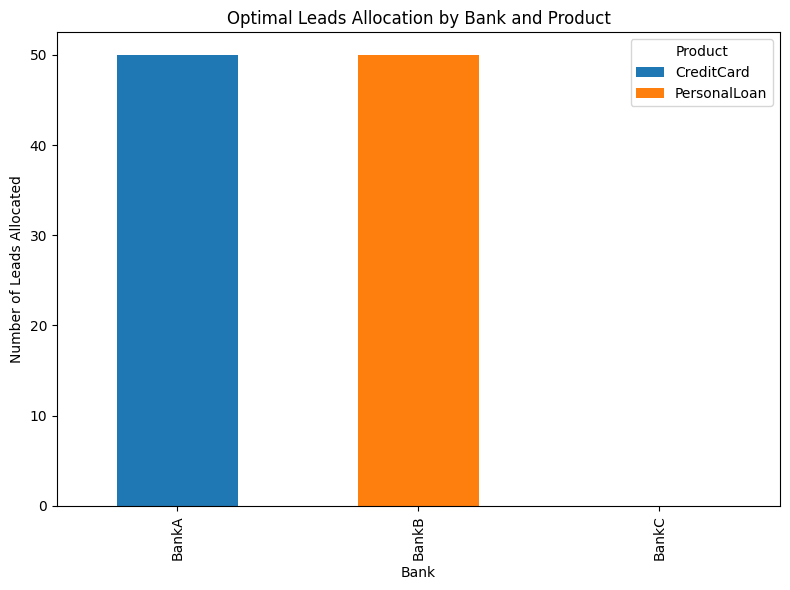

In [1]:
import random
import pandas as pd
import matplotlib.pyplot as plt
from pulp import LpMaximize, LpProblem, LpVariable, lpSum, LpInteger

# --------------------
# 1. SIMULATED DATA
# --------------------
# Let's say we have 3 banks and 2 products
banks = ["BankA", "BankB", "BankC"]
products = ["CreditCard", "PersonalLoan"]

# For each bank-product pair, define a random revenue and cost
random.seed(42)  # for reproducibility

# Revenue per lead (r_{i,j})
revenue = {
    (b, p): random.randint(50, 100) for b in banks for p in products
}

# Cost per lead (c_{i,j}), e.g., SMS or marketing cost
cost = {
    (b, p): random.randint(5, 15) for b in banks for p in products
}

# We define max leads we can allocate in total (L)
L = 100  # Suppose we can only send 100 leads in total

# Optionally define capacity constraints for each bank-product
# e.g., each bank-product can handle up to 50 leads in this example
U = {
    (b, p): 50 for b in banks for p in products
}

# --------------------
# 2. BUILD ILP MODEL
# --------------------
model = LpProblem("Maximize_Profit", LpMaximize)

# Create decision variables x_{i,j}, each must be an integer >= 0
x = {
    (b, p): LpVariable(name=f"x_{b}_{p}", lowBound=0, cat=LpInteger)
    for b in banks
    for p in products
}

# Objective function: Maximize sum((revenue - cost)*x_{i,j})
model += lpSum((revenue[(b,p)] - cost[(b,p)]) * x[(b,p)] for b in banks for p in products), "Total_Profit"

# Constraint 1: total leads <= L
model += lpSum(x[(b,p)] for b in banks for p in products) <= L, "Total_Leads_Limit"

# Constraint 2: capacities x_{i,j} <= U_{i,j}
for b in banks:
    for p in products:
        model += x[(b,p)] <= U[(b,p)], f"Cap_{b}_{p}"

# --------------------
# 3. SOLVE MODEL
# --------------------
model.solve()

# --------------------
# 4. EXTRACT RESULTS
# --------------------
print("Status:", model.status)
print("Objective (Max Profit):", model.objective.value())

# Construct a dataframe for the solution
solution_data = []
for b in banks:
    for p in products:
        solution_data.append({
            "Bank": b,
            "Product": p,
            "AllocatedLeads": x[(b,p)].value(),
            "RevenuePerLead": revenue[(b,p)],
            "CostPerLead": cost[(b,p)],
            "ProfitPerLead": revenue[(b,p)] - cost[(b,p)]
        })

df_solution = pd.DataFrame(solution_data)
print("\nSolution Allocations:")
print(df_solution)

# --------------------
# 5. VISUALIZE RESULT
# --------------------
# Example: Bar chart of leads allocated by (Bank, Product)
pivot_table = df_solution.pivot(index="Bank", columns="Product", values="AllocatedLeads")

pivot_table.plot(kind="bar", stacked=True, figsize=(8, 6))
plt.title("Optimal Leads Allocation by Bank and Product")
plt.xlabel("Bank")
plt.ylabel("Number of Leads Allocated")
plt.legend(title="Product")
plt.tight_layout()
plt.show()